# Installations that cause frequent errors on TPU

In [1]:
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 6.0 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


# Set Environment

In [2]:
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
import matplotlib.pyplot as plt
import pandas as pd

import pickle
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, BatchNormalization, Activation, Concatenate, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import LearningRateScheduler
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import gc

D0824 09:51:41.567255475      14 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0824 09:51:41.567283189      14 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0824 09:51:41.567286933      14 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0824 09:51:41.567290038      14 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0824 09:51:41.567292916      14 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0824 09:51:41.567295924      14 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0824 09:51:41.567298849      14 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D0824 09:51:41.

TensorFlow version: 2.12.0


# Set Seed for Reproducibility

In [3]:
def set_seed(seed=21019):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    #os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Loading data splits and one-hot encoding

In [4]:
print('Loaing data ...')
with open('/kaggle/input/data-split-for-cyenet/data_splits_for_cyenet.pkl', 'rb') as f:
    loaded_splits = pickle.load(f)

x_train = loaded_splits['x_train']
x_val = loaded_splits['x_val']
x_test = loaded_splits['x_test']
y_train = loaded_splits['y_train']
y_val = loaded_splits['y_val']
y_test = loaded_splits['y_test']

y_train_encoded = to_categorical(y_train)
y_val_encoded = to_categorical(y_val)
y_test_encoded = to_categorical(y_test)

print(f'Samples in Train Set: {len(y_train_encoded)}')
print(f'Samples in Validation Set: {len(y_val_encoded)}')
print(f'Samples in Test Set: {len(y_test_encoded)}')

Loaing data ...
Samples in Train Set: 10044
Samples in Validation Set: 2512
Samples in Test Set: 3140


# Creating the CYENET model

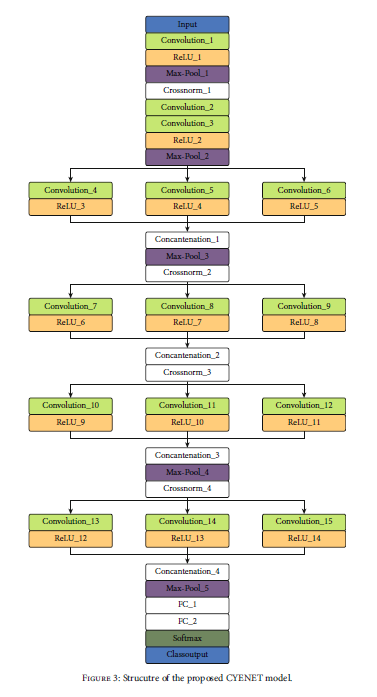

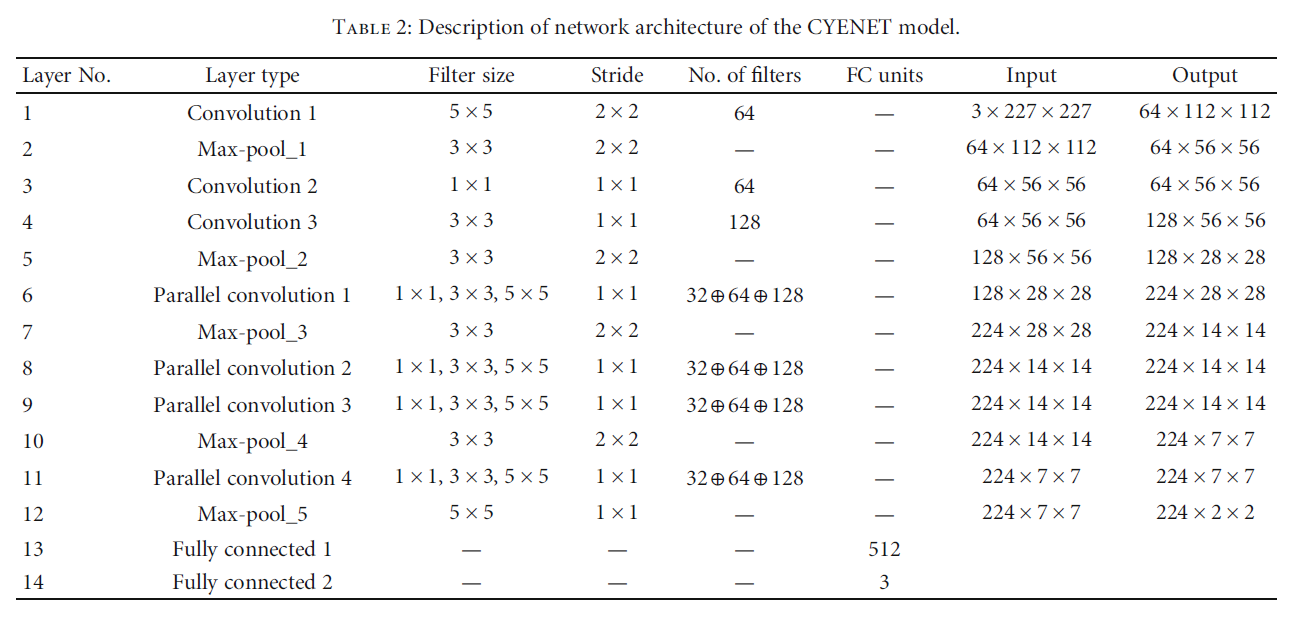

In [5]:
# Define class names
class_names = list(['Type 1','Type 2','Type 3'])

# Parallel convolution block
def parallel_conv_block(x_in):
    # First convolutional branch
    conv1 = Conv2D(32, 3, padding='same')(x_in)
    conv1 = Activation('relu')(conv1)
    
    # Second convolutional branch
    conv2 = Conv2D(64, 3, padding='same')(x_in)
    conv2 = Activation('relu')(conv2)
    
    # Third convolutional branch
    conv3 = Conv2D(128, 3, padding='same')(x_in)
    conv3 = Activation('relu')(conv3)
    
    # Concatenate the outputs of the three branches
    x_out = Concatenate()([conv1, conv2, conv3])
    
    return x_out

# Define the input shape
input_shape = x_train[0].shape

# Define the input tensor
inputs = Input(shape=input_shape)


# First Convolutional Block
x = Conv2D(64, 5, strides=2)(inputs)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, 1, strides=1)(x)
x = Conv2D(128, 3, strides=1, padding='same')(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
# First parallel convolution
x = parallel_conv_block(x)
x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
# Second parallel convolution
x = parallel_conv_block(x)
x = BatchNormalization()(x)
# Third parallel convolution
x = parallel_conv_block(x)
x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
# Fourth parallel convolution
x = parallel_conv_block(x)
x = MaxPooling2D(pool_size=5, strides=2)(x)

# Flatten before dense layers
x = Flatten()(x)

# Output layers fully connected with random initialization
x = Dense(512, activation='relu', kernel_initializer='random_uniform')(x)
x = Dense(len(class_names), kernel_initializer='random_uniform')(x)
outputs = Activation('softmax')(x)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the summary of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 227, 227, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  4864        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 112, 112, 64  0           ['conv2d[0][0]']                 
                                )                                                             

In [6]:
# Plot the model
tf.keras.utils.plot_model(
    model,
    to_file="CYENETreplicated.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=600,
    layer_range=None,
    show_layer_activations=True,
    show_trainable=False,
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


# Train Model

In [7]:
# Remove garbage to free up memory
print(f'Freeing up memory!')
gc.collect()

# Define the learning rate scheduler function
def lr_scheduler(epoch, lr):
    new_lr = lr * 0.01 if epoch % 10 == 0 else lr
    return new_lr

# Create the LearningRateScheduler callback
lr_callback = LearningRateScheduler(lr_scheduler)

# Train the model with history tapping (keeps data in a dictionary)
epochs = 50
batch_size = 64
history = model.fit(x_train, y_train_encoded, 
                    validation_data=(x_val,y_val_encoded),
                    epochs=epochs, 
                    batch_size=batch_size,
                    callbacks=[lr_callback],
                    shuffle=True
                   )

Freeing up memory!
Epoch 1/50
157/157 [==============================] - 112s 686ms/step - loss: 1.1120 - accuracy: 0.3627 - val_loss: 1.1063 - val_accuracy: 0.3439 - lr: 1.0000e-06
Epoch 2/50
157/157 [==============================] - 105s 666ms/step - loss: 1.0721 - accuracy: 0.4089 - val_loss: 1.0733 - val_accuracy: 0.4104 - lr: 1.0000e-06
Epoch 3/50
157/157 [==============================] - 105s 671ms/step - loss: 1.0495 - accuracy: 0.4403 - val_loss: 1.0545 - val_accuracy: 0.4319 - lr: 1.0000e-06
Epoch 4/50
157/157 [==============================] - 106s 675ms/step - loss: 1.0344 - accuracy: 0.4575 - val_loss: 1.0433 - val_accuracy: 0.4522 - lr: 1.0000e-06
Epoch 5/50
157/157 [==============================] - 106s 674ms/step - loss: 1.0193 - accuracy: 0.4759 - val_loss: 1.0342 - val_accuracy: 0.4578 - lr: 1.0000e-06
Epoch 6/50
157/157 [==============================] - 105s 670ms/step - loss: 1.0073 - accuracy: 0.4888 - val_loss: 1.0264 - val_accuracy: 0.4678 - lr: 1.0000e-06
Epo

# Evaluate Model

In [8]:
loss, accuracy = model.evaluate(x_test, y_test_encoded)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

99/99 [==============================] - 6s 65ms/step - loss: 0.9915 - accuracy: 0.5029
Test loss: 0.9915
Test accuracy: 0.5029


# Classification Report

In [9]:
# Get the true labels and predicted probabilities for the test data
# Make predictions on new images
predictions = model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)

# Generate the classification report
report = classification_report(y_test, predicted_classes, target_names=class_names)
print("Classification Report:\n", report)

99/99 [==============================] - 7s 61ms/step
Classification Report:
               precision    recall  f1-score   support

      Type 1       0.56      0.52      0.54      1030
      Type 2       0.43      0.42      0.42      1042
      Type 3       0.52      0.57      0.54      1068

    accuracy                           0.50      3140
   macro avg       0.50      0.50      0.50      3140
weighted avg       0.50      0.50      0.50      3140



# Confusion Matrix

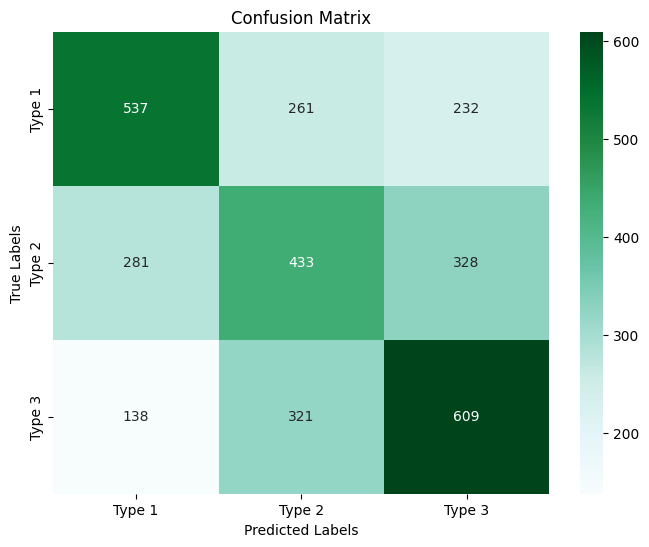

In [10]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="BuGn", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Taining Curves

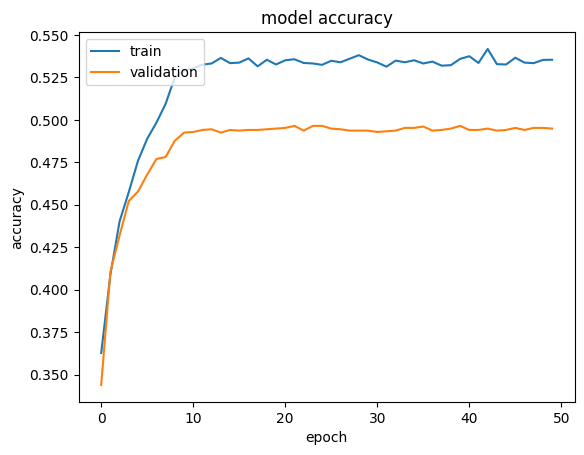

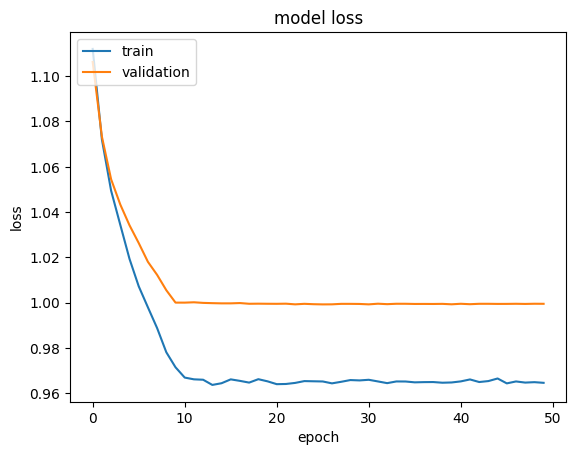

In [11]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()